In [0]:

!pip install keras-tqdm

In [0]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from google.colab import drive
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot
from keras.callbacks import History 
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded


# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/InertialSignals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + '/content/drive/My Drive/UCIHARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + '/content/drive/My Drive/UCIHARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [0]:
def RNN_model_build(trainX, trainy, testX, testy):
  verbose, epochs, batch_size = 0, 15, 64
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(SimpleRNN(units=100,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
  model.add(SimpleRNN(units=100,return_sequences=True))
  model.add(SimpleRNN(units=100,return_sequences=True))
  model.add(SimpleRNN(units=100,return_sequences=True))
  model.add(SimpleRNN(units=100))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])
  rnn = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[TQDMNotebookCallback()])
  rnn_ev = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
  return model, rnn, rnn_ev

In [0]:
trainX, trainy, testX, testy = load_dataset()
RNN_model, rnn, rnn_ev = RNN_model_build(trainX, trainy, testX, testy)
RNN_model.summary()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_66 (SimpleRNN)    (None, 128, 100)          11000     
_________________________________________________________________
simple_rnn_67 (SimpleRNN)    (None, 128, 100)          20100     
_________________________________________________________________
simple_rnn_68 (SimpleRNN)    (None, 128, 100)          20100     
_________________________________________________________________
simple_rnn_69 (SimpleRNN)    (None, 128, 100)          20100     
_________________________________________________________________
simple_rnn_70 (SimpleRNN)    (None, 100)               20100     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
__________

In [0]:
print('Accuracy of RNN Model: %.3f' % ((np.sum(rnn.history['acc'])/15)*100))
print('RMSE of RNN Model: %.3f' % (math.sqrt(np.sum(rnn.history['mean_squared_error'])/15)))

Accuracy of RNN Model: 62.882
RMSE of RNN Model: 0.277


In [0]:
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
  
  
print(confusion_matrix(testy, RNN_model.predict(testX)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_UPSTAIRS
True                                                                    
LAYING                 537        0         0        0                 0
SITTING                  1      334       145        3                 8
STANDING                 0       89       420       14                 9
WALKING                 10       19       150      148               169
WALKING_DOWNSTAIRS      20       11       120      110               159
WALKING_UPSTAIRS         3        2       106      143               217


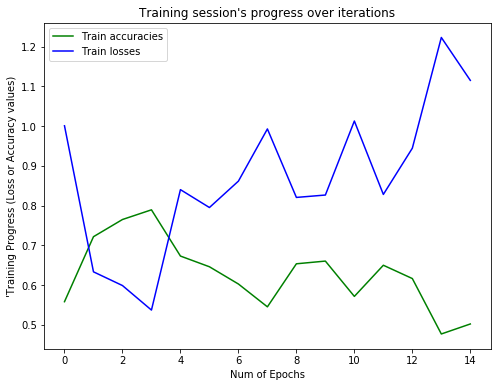

In [0]:
plt.figure() 
plt.plot(rnn.history['acc'],"g", label="Train accuracies")
plt.plot(rnn.history['loss'],"b", label="Train losses")
plt.xticks(np.arange(0, 16, 2.0)) 
plt.rcParams['figure.figsize'] = (8, 6) 
plt.xlabel("Num of Epochs") 
plt.ylabel("'Training Progress (Loss or Accuracy values)") 
plt.title("Training session's progress over iterations") 
plt.legend(['Train accuracies','Train losses']) 
plt.show()

In [0]:
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(testy, axis=1)])
Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(RNN_model.predict(testX), axis=1)])
report = classification_report(Y_true, Y_pred)
print(report)

                    precision    recall  f1-score   support

            LAYING       0.94      1.00      0.97       537
           SITTING       0.73      0.68      0.71       491
          STANDING       0.45      0.79      0.57       532
           WALKING       0.35      0.30      0.32       496
WALKING_DOWNSTAIRS       0.00      0.00      0.00       420
  WALKING_UPSTAIRS       0.39      0.46      0.42       471

         micro avg       0.56      0.56      0.56      2947
         macro avg       0.48      0.54      0.50      2947
      weighted avg       0.50      0.56      0.52      2947



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


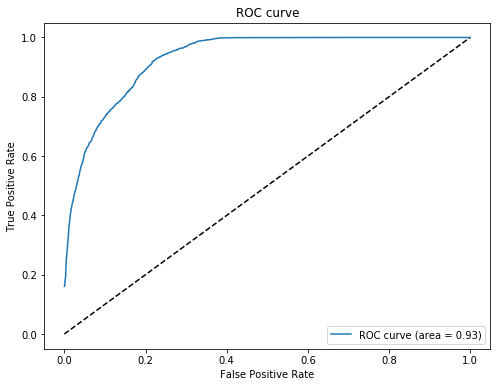

In [0]:
n_classes = 6

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy[:, i], rnn_pr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["weighted"] = all_fpr
tpr["weighted"] = mean_tpr
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr["weighted"], tpr["weighted"],
         label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["weighted"]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

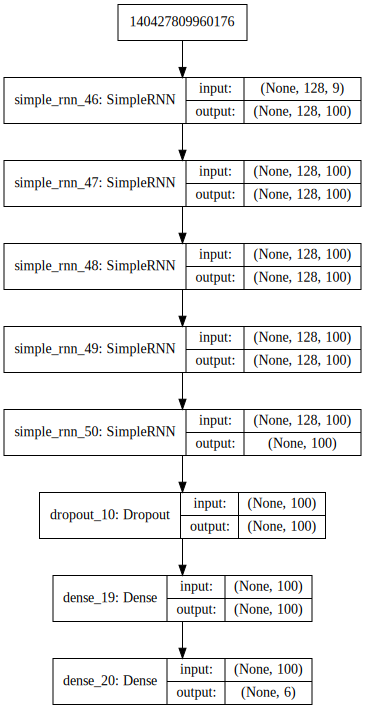

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(RNN_model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [0]:
def LSTM_model_build(trainX, trainy, testX, testy):
  verbose, epochs, batch_size = 0, 15, 64
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(LSTM(100, return_sequences=True, input_shape=(n_timesteps,n_features)))
  model.add(LSTM(100, return_sequences=True))
  model.add(LSTM(100, return_sequences=True))
  model.add(LSTM(100, return_sequences=True))
  model.add(LSTM(100))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])
  lstm = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[TQDMNotebookCallback()])
  lstm_ev = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
  return model, lstm, lstm_ev

In [0]:
trainX, trainy, testX, testy = load_dataset()
LSTM_model, lstm, lstm_ev = LSTM_model_build(trainX, trainy, testX, testy)
LSTM_model.summary()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128, 100)          44000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 128, 100)          80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 128, 100)          80400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 128, 100)          80400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
__________

In [0]:
print('Accuracy of LSTM Model: %.3f' % ((np.sum(lstm.history['acc'])/15)*100))
print('RMSE of LSTM Model: %.3f' % (math.sqrt(np.sum(lstm.history['mean_squared_error'])/15)))

Accuracy of LSTM Model: 84.225
RMSE of LSTM Model: 0.187


In [0]:
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
  
  
print(confusion_matrix(testy, LSTM_model.predict(testX)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      358       126        7                   0   
STANDING                 0       48       475        9                   0   
WALKING                  0        0         0      465                  27   
WALKING_DOWNSTAIRS       0        0         0        0                 419   
WALKING_UPSTAIRS         0        0         0       27                  52   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                            4  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 392  


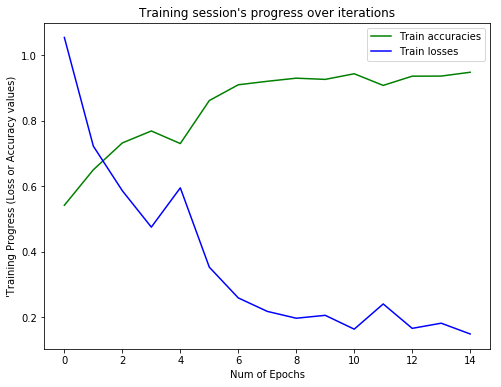

In [0]:
plt.figure() 
plt.plot(lstm.history['acc'],"g", label="Train accuracies")
plt.plot(lstm.history['loss'],"b", label="Train losses")
plt.xticks(np.arange(0, 16, 2.0)) 
plt.rcParams['figure.figsize'] = (8, 6) 
plt.xlabel("Num of Epochs") 
plt.ylabel("'Training Progress (Loss or Accuracy values)") 
plt.title("Training session's progress over iterations") 
plt.legend(['Train accuracies','Train losses']) 
plt.show()

In [0]:
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(testy, axis=1)])
Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(LSTM_model.predict(testX), axis=1)])
report = classification_report(Y_true, Y_pred)
print(report)

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.88      0.73      0.80       491
          STANDING       0.79      0.89      0.84       532
           WALKING       0.92      0.94      0.93       496
WALKING_DOWNSTAIRS       0.84      1.00      0.91       420
  WALKING_UPSTAIRS       0.99      0.83      0.90       471

         micro avg       0.90      0.90      0.90      2947
         macro avg       0.90      0.90      0.90      2947
      weighted avg       0.90      0.90      0.90      2947



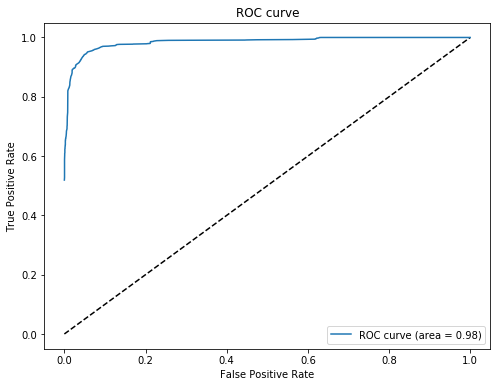

In [0]:
lstm_pr = LSTM_model.predict(testX) 

n_classes = 6

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy[:, i], lstm_pr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["weighted"] = all_fpr
tpr["weighted"] = mean_tpr
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr["weighted"], tpr["weighted"],
         label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["weighted"]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

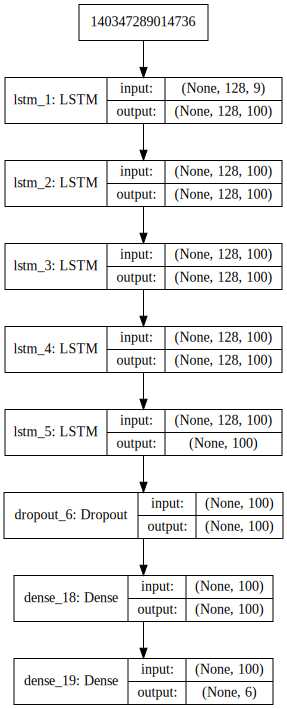

In [0]:
SVG(model_to_dot(LSTM_model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))